# Reputation Era
### How does the reputation of artists changes in time?

This notebook contains the data mining and data analysis of the project Reoutation Era, developed by Erica Andreose, Giorgia Crosilla and Daniele Spedicati in the context of the exam of Information Visualization. 

The project aims to explore the oscillations in reputation that different artists face during time through data. 

The concept of reputation is difficult to define and many definition could be given [inserire qualche riferimento agli articoli.]

## The Datasets
In this project, we focused on three main variables to define the reputation of an artist:
* Auctions [dire sorgente dati]
* Pubblications about the artist [ dire sorgente dati]
* One-Man Exhibition 

## Our Case studies - De Kooning and Klimt
As an exaple for our study we took two well-known artist, De Kooning and Klimt. 
### De cooning - a "ground trouth" case. 
### Klimt - a research case.

# Working with data

In [25]:
# import all useful libraries

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## 1. Auctions dataset

In [26]:
# import the auctionons dataset as a Pandas DataFrame
pd.set_option('display.max_columns', None)
getty2 = pd.read_csv("auctions.csv", sep=";", encoding="iso-8859-1")
getty2

,Column1,artist,country,yearOfBirth,yearOfDeath,name,year,price,material,height,width,link,source,dominantColor,brightness,ratioUniqueColors,thresholdBlackPerc,highbrightnessPerc,lowbrightnessPerc,CornerPer,EdgePer,FaceCount,soldtime
0,0.0,Mario A,Swiss,1959,NaN,The world is beautyful #5,2004,53150.0,laserchrome_print_diasec,29.53,39.37,http://artsalesindex.artinfo.com/asi/lots/3456055,http://artinfo-images-350.s3.amazonaws.com/asi...,yellows,980.0,25.0,6574.0,75.0,2156.0,37.0,402.0,10.0,NaN
1,1.0,Mario A,Swiss,1959,NaN,The world is beautyful #13,2004,73830.0,laserchrom_print_(diasec.),29.53,39.37,http://artsalesindex.artinfo.com/asi/lots/3456059,http://artinfo-images-350.s3.amazonaws.com/asi...,blacks,730.0,19.0,6617.0,1521.0,465.0,152.0,728.0,0.0,NaN
2,2.0,A E Cremer,French,20thC,NaN,Spot Lights,NaN,20900.0,black-painted_metal,NaN,NaN,http://artsalesindex.artinfo.com/asi/lots/5250074,http://artinfo-images-350.s3.amazonaws.com/asi...,whites,2120.0,5.0,2017.0,0.0,1756.0,39.0,415.0,0.0,NaN
3,3.0,A G Schultz & Co.,American,est1890s,NaN,Sugar/Sweetmeat Baskets,NaN,6150.0,Sterling_Silver,6.5,5.75,http://artsalesindex.artinfo.com/asi/lots/5269624,http://artinfo-images-350.s3.amazonaws.com/asi...,blacks,730.0,18.0,830.0,1374.0,3574.0,358.0,1313.0,0.0,NaN
4,4.0,A G Schultz & Co.,American,est1890s,NaN,An American Silver Five-piece Tea And Coffee S...,1908,81250.0,silver,NaN,NaN,http://artsalesindex.artinfo.com/asi/lots/3900522,http://artinfo-images-350.s3.amazonaws.com/asi...,whites,2160.0,2.0,1126.0,0.0,627.0,125.0,1295.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44097,41290.0,Mark Rothko,American,1903.0,19700.0,Untitled,1961,17000000.0,oil_on_canvas,93.0,80.0,http://artsalesindex.artinfo.com/asi/lots/2495060,http://artinfo-images-350.s3.amazonaws.com/177...,reds,1070.0,6.0,9899.0,0.0,0.0,14.0,32.0,0.0,1997-11-18 00:00:00
44098,41291.0,Mark Rothko,American,1903.0,19700.0,Untitled,1968,3000000.0,acrylic_on_paper_on_canvas,24.0,18.0,http://artsalesindex.artinfo.com/asi/lots/2495081,http://artinfo-images-350.s3.amazonaws.com/177...,reds,1340.0,1.0,6856.0,0.0,0.0,56.0,45.0,0.0,1997-11-18 00:00:00
44099,41292.0,Mark Rothko,American,1903.0,19700.0,Untitled,1959,2800000.0,oil_on_paper_laid_on_masonite,38.0,25.0,http://artsalesindex.artinfo.com/asi/lots/2495098,http://artinfo-images-350.s3.amazonaws.com/177...,blacks,1100.0,7.0,5348.0,66.0,475.0,14.0,107.0,0.0,1997-11-18 00:00:00
44100,41293.0,Mark Rothko,American,1903.0,19700.0,"Green, White, Green on Blue",1969,3229380.0,oil_on_paper_on_board,71.0,41.0,http://artsalesindex.artinfo.com/asi/lots/2251703,http://artinfo-images-350.s3.amazonaws.com/S11...,blacks,250.0,8.0,9498.0,947.0,4295.0,22.0,197.0,0.0,1995-11-29 00:00:00


### a. Brief overview

In [27]:
# creating a dictionary with the frequency of each artist

from collections import Counter
liss = {}
for column_name in getty2.columns:
    if column_name == "artist":
        for value in getty2[column_name]:
            if value not in liss:
                liss[value] = 1
            else:
                liss[value] += 1
k = Counter(liss)
 
# Finding 20 highest values
high = k.most_common(20) 
 
print("Initial Dictionary:")
print(liss, "\n")
print ('Total artist', len(liss))
 
 
print("Dictionary with 3 highest values:")
print("Keys: Values")
 
for i in high:
    print(i[0]," :",i[1]," ")

Initial Dictionary:
{'Mario A': 2, 'A E Cremer': 1, 'A G Schultz & Co.': 2, 'A H': 1, 'A H G': 1, 'A K': 1, 'A Kassen': 1, 'A Lao': 4, 'A M': 1, 'A Sun Wu': 4, "Maria A'Becket": 4, "A'erbai": 1, 'A-One': 2, 'A.CE': 1, 'A1one': 6, 'Dirk van der Aa': 6, 'Jorgen Aabye': 5, 'Christian Aabye-Talge': 1, 'Attributed to  Hans von Aachen': 2, 'Circle of  Hans von Aachen': 2, 'Studio of  Hans von Aachen': 1, 'After  Hans von Aachen': 1, 'Hans von Aachen': 1, 'Peder Pedersen Aadnes': 1, 'Arvid Aae': 2, 'Carl Frederic Aagaard': 4, 'Martin Aagaard': 2, 'H P Aaland': 1, 'Alvar Aalto': 11, nan: 2837, 'Ilmari Aalto': 4, 'Veikko Aaltona': 5, 'Aarre Aaltonen': 2, 'Waino Aaltonen': 7, 'Martin Aalund': 3, 'Asbjorn Aamodt': 2, 'Susanne Aamund': 1, 'Jos Aanraad': 3, 'Leny Aardse': 1, 'Eero Aarnio': 7, 'Jessie Aaron': 9, 'John Aaron': 1, 'Joseph Aaron': 5, 'Michel Aaron': 1, 'George Aarons': 4, 'Slim Aarons': 2, 'Carl Aarsleff': 2, 'Hans Aarsman': 1, 'Nicolaas Aartmann': 4, 'Pieter Jan Aarts': 1, 'Alf Jorgen

In [28]:
# Explore the distribution of data in our

# Extract keys with value 1
keys_with_value_1 = [key for key, value in k.items() if value == 1]

# Count of keys with value 1
count_keys_with_value_1 = len(keys_with_value_1)


# Extract keys with value between 1 and 5
keys_with_value_minor_5 = [key for key, value in k.items() if 1 < value <= 5]

# Count of keys with value 5
count_keys_with_value_minor_5 = len(keys_with_value_minor_5)


# extract keys with value between 5 and 10
keys_with_value_minor_10= [key for key, value in k.items() if 5 < value <= 10]

# Count of keys with value between 5 and 10
count_keys_with_value_minor_10 = len(keys_with_value_minor_10)


# extract keys with value greater than 10
keys_with_value_greater_10= [key for key, value in k.items() if value > 10]

# Count of keys with value greater than 10
count_keys_with_value_greater_10 = len(keys_with_value_greater_10)
    

# Organise data in a df

data = {'labels':['Artist with one auction', 'Artists with maximum 5 auctions', 'Artist with maximum 10 auctions', 'Artists with more than 10 auctions'],
        'values' : [count_keys_with_value_1, count_keys_with_value_minor_5, count_keys_with_value_minor_10, count_keys_with_value_greater_10]
}

auctions_count = pd.DataFrame(data)

# Calculate the sum of 'values' column
total_value = auctions_count['values'].sum()

# Add a new row with the label "Artists in the dataset" and the sum of all values
new_row = {'labels': ['Artists in the dataset'], 'values': [total_value]}
total_df = pd.DataFrame(new_row)
# Concatenate the original DataFrame with the new total row DataFrame
auctions_count = pd.concat([auctions_count, total_df], ignore_index=True)
# Calculate percentages
auctions_count['percentage'] = (auctions_count['values'] / total_value) * 100


auctions_count


,labels,values,percentage
0,Artist with one auction,4044,46.919596
1,Artists with maximum 5 auctions,3363,39.018448
2,Artist with maximum 10 auctions,1195,13.864717
3,Artists with more than 10 auctions,17,0.197239
4,Artists in the dataset,8619,100.000000


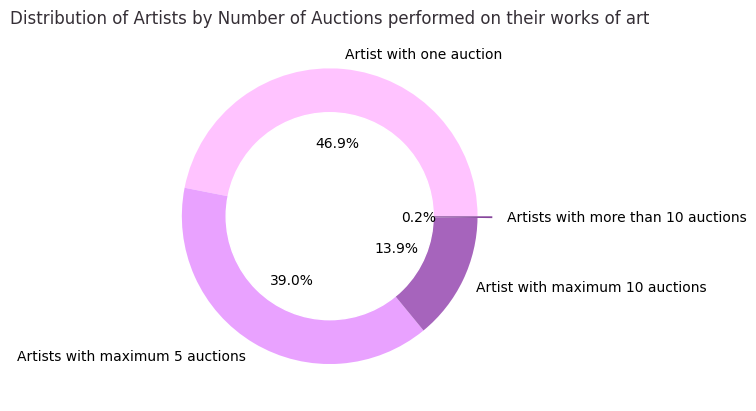

In [29]:
#create donut chart from data above

# settings
sizes = [count_keys_with_value_1, count_keys_with_value_minor_5, count_keys_with_value_minor_10, count_keys_with_value_greater_10]
labels = ['Artist with one auction', 'Artists with maximum 5 auctions', 'Artist with maximum 10 auctions', 'Artists with more than 10 auctions']
colors = ['#FFC3FF','#E9A2FF','#A664BC','#86469C']
explode = [0, 0, 0, 0.1]
# Create a pieplot
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=0, pctdistance=0.5)

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Distribution of Artists by Number of Auctions performed on their works of art', color = '#352f36')

plt.show()

In [30]:
#create bar chart of frequency of auctions for artists with more than 10 auctions performed on their works.

#create dictionary with only above 10
greater_10_dict = {}
for key, value in high:
    if value > 10 :
        greater_10_dict[key] = value

data = {'artist': greater_10_dict.keys(), 'number of auctions': greater_10_dict.values()}


greater_10_df = pd.DataFrame(data)

greater_10_df

,artist,number of auctions
0,Pablo Picasso,8975
1,Andy Warhol,6976
2,NaN,2837
3,Gustav Klimt,424
4,Paul Cezanne,384
5,Willem de Kooning,381
6,Edvard Munch,371
7,After Pablo Picasso,339
8,Vincent van Gogh,133
9,Mark Rothko,133


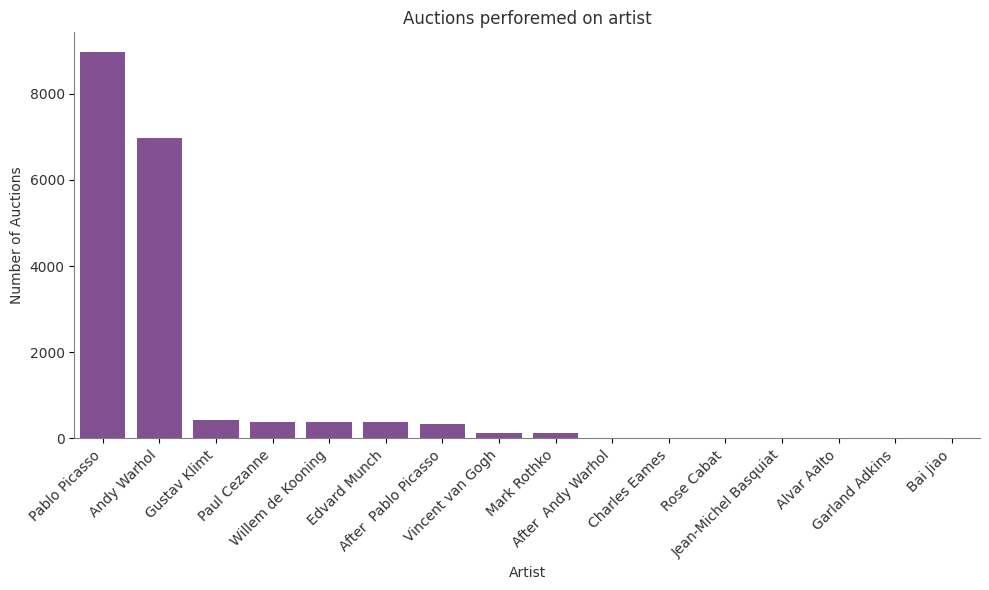

In [31]:
# create a barplot of the artist with more than 10 aucitons performed on their works

plt.figure(figsize=(10, 6))

# Set the style and color of the axes
sns.set_style({'axes.edgecolor': 'gray'})

sns.barplot(x='artist', y='number of auctions', data=greater_10_df, color='#86469C')
plt.xticks(rotation=45, ha='right', color = '#352f36') 
plt.yticks(color = '#352f36')
plt.title('Auctions perforemed on artist', color = '#352f36')
plt.xlabel('Artist', color = '#352f36')
plt.ylabel('Number of Auctions', color = '#352f36')
sns.despine()
plt.tight_layout()
plt.show()

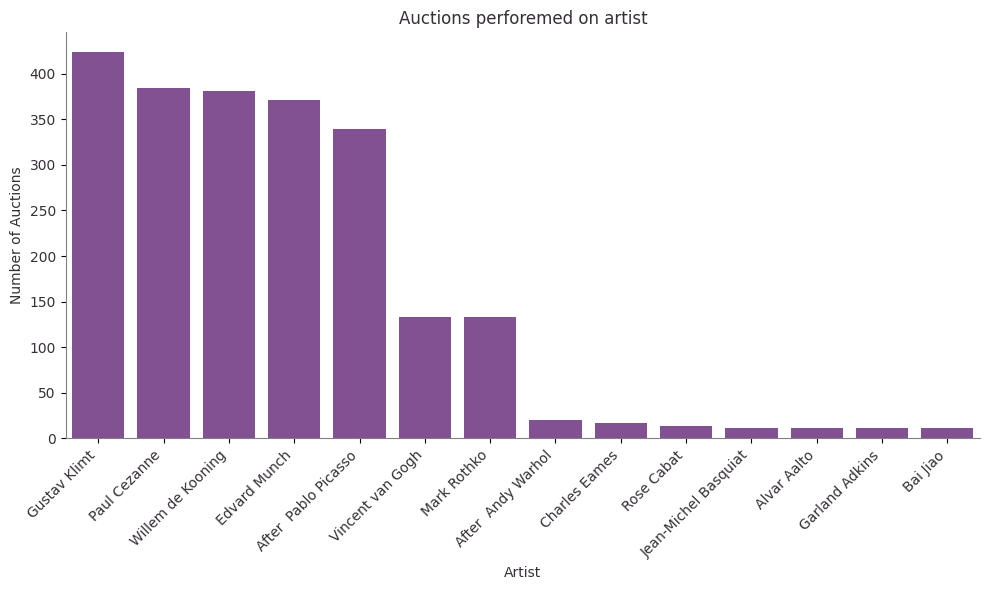

In [32]:
# barplot without the top two
greater_10_df_filtered = greater_10_df.iloc[2:]

plt.figure(figsize=(10, 6))

# Set the style and color of the axes
sns.set_style({'axes.edgecolor': 'gray'})

sns.barplot(x='artist', y='number of auctions', data=greater_10_df_filtered, color='#86469C')
plt.xticks(rotation=45, ha='right', color = '#352f36') 
plt.yticks(color = '#352f36')
plt.title('Auctions perforemed on artist', color = '#352f36')
plt.xlabel('Artist', color = '#352f36')
plt.ylabel('Number of Auctions', color = '#352f36')
sns.despine()
plt.tight_layout()
plt.show()

This preliminary research shows us that the data in our dataset are not omogeneus. Although, we have a small group of istances that present an adequate number of data. The two artist that we are focusing on in this study (De Kooning and Klimt) are both in this subset. This encourage us to continue in our analysis.

# Studying two artists: De Kooning and Klimt
## 1. Times a work has been sold

In [33]:
# Count De Kooning frequency

liss_dk = []
for column_name in getty2.columns:
    if column_name == "artist":
        for value in getty2[column_name]:
            if value == "Willem de Kooning":
                liss_dk.append(value)
print(len(liss_dk))

381


Get only results related to sales on De Kooning works. Artworks that do not possess data about price or soldtime have been deleted from the dataset.
The dataset does not possess any data related to sellers and buyers. 
In this example we notice that 307 works over a total of 381 possess data about price and time of the transaction. 

In [34]:
import pandas as pd

new_dataframe_dk = getty2[["artist", "name", "price", "soldtime"]].copy()
new_dataframe_dk= new_dataframe_dk[new_dataframe_dk["artist"] == "Willem de Kooning"].copy()

new_dataframe_dk.reset_index(drop=True, inplace=True)

for idx, row in new_dataframe_dk.iterrows():
    if pd.isna(row["price"]) and pd.isna(row["soldtime"]):
        new_dataframe_dk.drop(idx, inplace=True)
        
dayy = []
for i in new_dataframe_dk['soldtime']:
    string_representation = str(i)
    split_parts = string_representation.split('-')
    day = split_parts[0]
    dayy.append(day)
new_dataframe_dk['soldtime'] = dayy
        

new_dataframe_dk.reset_index(drop=True, inplace=True)
new_dataframe_dk.to_csv('auctions_data_DK.csv', index=False)
new_dataframe_dk

,artist,name,price,soldtime
0,Willem de Kooning,Untitled,1370000.0,2014
1,Willem de Kooning,Untitled,20450000.0,2014
2,Willem de Kooning,Untitled,1125000.0,2014
3,Willem de Kooning,Untitled XVIII,48690000.0,2014
4,Willem de Kooning,Untitled XXIV,175250000.0,2014
...,...,...,...,...
302,Willem de Kooning,Woman V,3130000.0,2008
303,Willem de Kooning,Untitled IV,120810000.0,2008
304,Willem de Kooning,With love,44000.0,2008
305,Willem de Kooning,Untitled (Spoleto),1210000.0,2008


In [35]:
#Check if there are works that have been sold more than once

name_counts = new_dataframe_dk.groupby(['artist', 'name']).size().reset_index(name='count')

name_counts_sorted_dk = name_counts.sort_values(by='count', ascending=False)

name_counts_sorted_dk.reset_index(drop=True)


,artist,name,count
0,Willem de Kooning,Untitled,90
1,Willem de Kooning,Love to Wakako,6
2,Willem de Kooning,Woman,6
3,Willem de Kooning,High School Desk,6
4,Willem de Kooning,Woman with Corset and Long Hair,5
...,...,...,...
145,Willem de Kooning,Quatre Lithographies: One Print,1
146,Willem de Kooning,"Quatre Lithographies, Editions de la DiffÃ©ren...",1
147,Willem de Kooning,"Quatre Lithographies, Editions de la Diffrence...",1
148,Willem de Kooning,Preacher,1


From this initial overview we can notice that probably there are more than one "Untitled" work (the chances that one work was sold 90 times in eight years are very low). Our dataset did not provide a unique identifier for each work, which makes impossible to disambiguate it. 

In [36]:
# count the number of works sold how many times

# Count the occurrences of each count value
count_freq = name_counts_sorted_dk['count'].value_counts().sort_index()

# Create a DataFrame to store the count frequency data
count_data_dk = pd.DataFrame({'times_sold':count_freq.index , 'count': count_freq.values})

count_data_dk = count_data_dk.sort_values(by='times_sold', ascending=True)

# Modify the 'times_sold' column to become a string
count_data_dk['times_sold'] = 'sold ' + count_data_dk['times_sold'].astype(str) + ' times'

count_data_dk


,times_sold,count
0,sold 1 times,111
1,sold 2 times,22
2,sold 3 times,10
3,sold 4 times,1
4,sold 5 times,2
5,sold 6 times,3
6,sold 90 times,1


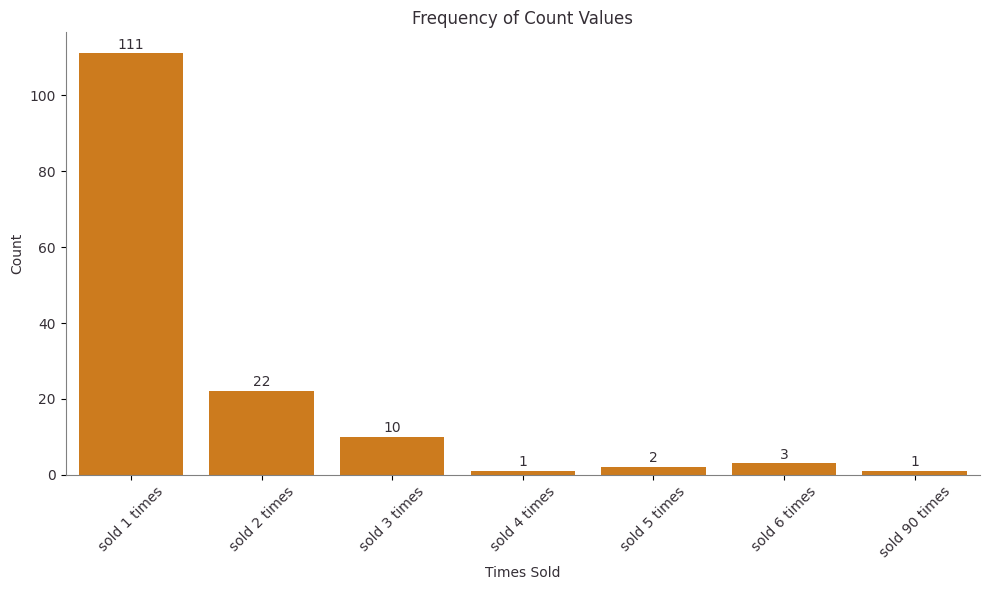

In [37]:

import seaborn as sns
import matplotlib.pyplot as plt

# Plot

# Set the style and color of the axes
sns.set_style({'axes.edgecolor': 'gray'})


plt.figure(figsize=(10, 6))
sns.barplot(x='times_sold', y='count', data=count_data_dk, color='#E97D01')
plt.title('Frequency of Count Values', color = '#352f36')
plt.xlabel('Times Sold', color = '#352f36')
plt.ylabel('Count', color = '#352f36')
plt.xticks(rotation=45, color = '#352f36')
plt.yticks(color = '#352f36')

# Add exact value on top of each bar
for index, value in enumerate(count_data_dk['count']):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom', color = '#352f36')

sns.despine()

plt.tight_layout()
plt.show()



In [38]:
# Count De Kooning frequency

liss_k = []
for column_name in getty2.columns:
    if column_name == "artist":
        for value in getty2[column_name]:
            if value == "Gustav Klimt":
                liss_k.append(value)
print(len(liss_k))

424


In [39]:
# Klimt data

new_dataframe_k = getty2[["artist", "name", "price", "soldtime"]].copy()
new_dataframe_k= new_dataframe_k[new_dataframe_k["artist"] == "Gustav Klimt"].copy()

new_dataframe_k.reset_index(drop=True, inplace=True)

for idx, row in new_dataframe_k.iterrows():
    if pd.isna(row["price"]) and pd.isna(row["soldtime"]):
        new_dataframe_k.drop(idx, inplace=True)
        
dayy = []
for i in new_dataframe_k['soldtime']:
    string_representation = str(i)
    split_parts = string_representation.split('-')
    day = split_parts[0]
    dayy.append(day)
new_dataframe_k['soldtime'] = dayy
        

new_dataframe_k.reset_index(drop=True, inplace=True)
new_dataframe_k.to_csv('auctions_data_k.csv', index=False)
new_dataframe_k

,artist,name,price,soldtime
0,Gustav Klimt,Vorgebeugt sitzende Aktfigur,174600.0,2014
1,Gustav Klimt,"Stehender Frauenakt Mit Erhobenem Linkem Bein,...",225000.0,2014
2,Gustav Klimt,Nach Links Sitzender Halbakt,200000.0,2014
3,Gustav Klimt,Allegory of Agriculture,200000.0,2014
4,Gustav Klimt,MÃ¤dchenbrustbild Von Vorne Mit HÃ¤ubchen (Por...,2691170.0,2014
...,...,...,...,...
251,Gustav Klimt,"Young nude with long, open hair",288000.0,2004
252,Gustav Klimt,Head and shoulders portrait of a lady glancing...,120140.0,2004
253,Gustav Klimt,Female nude bent over,192220.0,2004
254,Gustav Klimt,Lovers,180210.0,2004


In [40]:
#Check if there are works that have been sold more than once

name_counts = new_dataframe_k.groupby(['artist', 'name']).size().reset_index(name='count')

name_counts_sorted_k = name_counts.sort_values(by='count', ascending=False)

name_counts_sorted_k.reset_index(drop=True)

,artist,name,count
0,Gustav Klimt,Lovers,3
1,Gustav Klimt,Male nude,3
2,Gustav Klimt,Nude,3
3,Gustav Klimt,Adele Bloch-Bauer,2
4,Gustav Klimt,Seated nude,2
...,...,...,...
234,Gustav Klimt,Mada Primavesi,1
235,Gustav Klimt,Mannerkopf von vorne,1
236,Gustav Klimt,Mannerruckenakt,1
237,Gustav Klimt,Miss Lieser,1


In [41]:
# count the number of works sold how many times

# Count the occurrences of each count value
count_freq = name_counts_sorted_k['count'].value_counts().sort_index()

# Create a DataFrame to store the count frequency data
count_data_k = pd.DataFrame({'times_sold':count_freq.index , 'count': count_freq.values})

count_data_k = count_data_k.sort_values(by='times_sold', ascending=True)

# Modify the 'times_sold' column to become a string
count_data_k['times_sold'] = 'sold ' + count_data_k['times_sold'].astype(str) + ' times'

count_data_k


,times_sold,count
0,sold 1 times,225
1,sold 2 times,11
2,sold 3 times,3


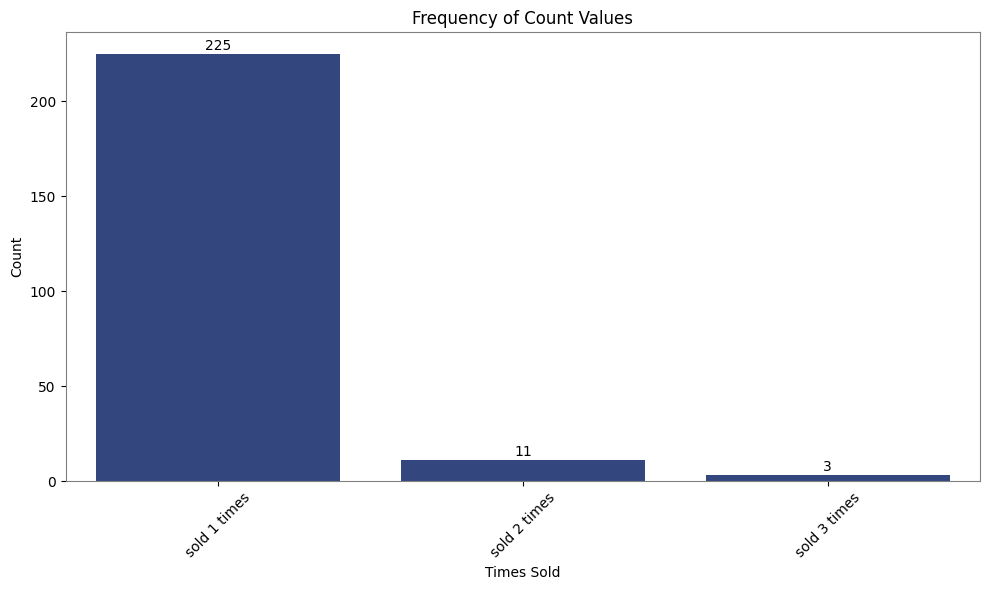

In [42]:

import seaborn as sns
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='times_sold', y='count', data=count_data_k, color='#26408B')
plt.title('Frequency of Count Values')
plt.xlabel('Times Sold')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add exact value on top of each bar
for index, value in enumerate(count_data_k['count']):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()



In [43]:
#Combine data

# Left merge df_dk and df_k on 'times_sold' column
merged_df = pd.merge(count_data_dk, count_data_k, on='times_sold', how='left')

# Fill NaN values with 0
merged_df = merged_df.fillna(0)

# Rename the 'count' columns
merged_df = merged_df.rename(columns={'count_x': 'de_kooning_count', 'count_y': 'klimt_count'})

# Convert count columns to integer data type
merged_df['de_kooning_count'] = merged_df['de_kooning_count'].astype(int)
merged_df['klimt_count'] = merged_df['klimt_count'].astype(int)

merged_df


,times_sold,de_kooning_count,klimt_count
0,sold 1 times,111,225
1,sold 2 times,22,11
2,sold 3 times,10,3
3,sold 4 times,1,0
4,sold 5 times,2,0
5,sold 6 times,3,0
6,sold 90 times,1,0


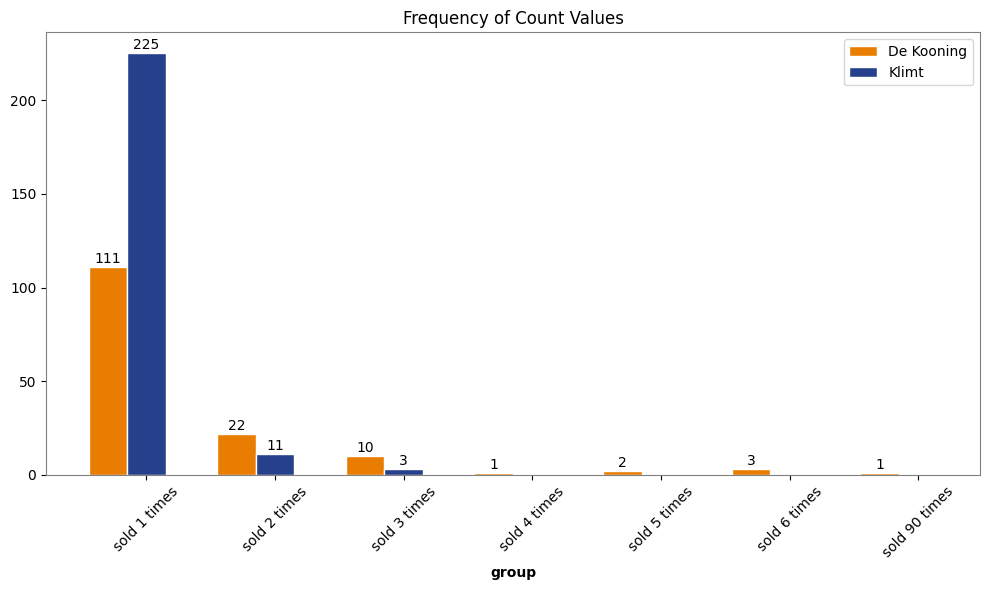

In [44]:
# set width of bars
barWidth = 0.3
 
# set heights of bars
bars1 = merged_df['de_kooning_count']
bars2 = merged_df['klimt_count']

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.figure(figsize=(10, 6))
plt.bar(r1, bars1, color='#E97D01', width=barWidth, edgecolor='white', label='De Kooning')
plt.bar(r2, bars2, color='#26408B', width=barWidth, edgecolor='white', label='Klimt')

for i, (dk_count, kl_count) in enumerate(zip(merged_df['de_kooning_count'], merged_df['klimt_count'])):
    if dk_count > 0:
        plt.text(i, dk_count + 0.5, str(dk_count), ha='center', va='bottom')
    if kl_count > 0:
        plt.text(i + barWidth, kl_count + 0.5, str(kl_count), ha='center', va='bottom')
 
# Add xticks on the middle of the group bars
plt.title('Frequency of Count Values')
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], merged_df['times_sold'], rotation=45)


plt.tight_layout()
 
# Create legend & Show graphic
plt.legend()
plt.show()


plt.show()

This first analys shows the dinamicity of the two artist: while more works by Klimt were sold, De Kooning's ones seem to be more mobile, capturing more the interst of the market???.

## 2. Sellings per year

In [52]:
import pandas as pd

# Assuming new_dataframe_dk is your DataFrame
# Assuming the column name is 'soldtime'

# Count the values in the 'soldtime' column
soldtime_counts = new_dataframe_dk['soldtime'].value_counts()

# Convert the Series to a DataFrame if needed
soldtime_counts_df = soldtime_counts.reset_index()
soldtime_counts_df.columns = ['soldtime', 'count']

# Sort the DataFrame by the 'soldtime' column
soldtime_counts_df_sorted_dk = soldtime_counts_df.sort_values(by='soldtime')

# Display the sorted DataFrame
soldtime_counts_df_sorted_dk



,soldtime,count
1,2008,48
6,2009,17
5,2010,34
2,2011,45
3,2012,41
0,2013,82
4,2014,40


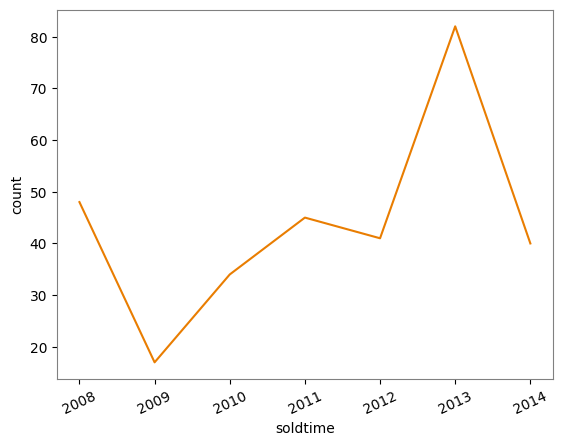

In [56]:
# plot timeline

sns.lineplot(x = "soldtime", y = "count", data = soldtime_counts_df_sorted_dk, color='#E97D01') 
  
plt.xticks(rotation = 25)

plt.show()

In [57]:
import pandas as pd

# Assuming new_dataframe_dk is your DataFrame
# Assuming the column name is 'soldtime'

# Count the values in the 'soldtime' column
soldtime_counts = new_dataframe_k['soldtime'].value_counts()

# Convert the Series to a DataFrame if needed
soldtime_counts_df = soldtime_counts.reset_index()
soldtime_counts_df.columns = ['soldtime', 'count']

# Sort the DataFrame by the 'soldtime' column
soldtime_counts_df_sorted_k = soldtime_counts_df.sort_values(by='soldtime')

# Display the sorted DataFrame
soldtime_counts_df_sorted_k



,soldtime,count
3,2004,21
0,2005,61
2,2006,32
1,2007,51
7,2008,15
6,2009,17
4,2010,18
8,2011,9
5,2012,17
10,2013,7


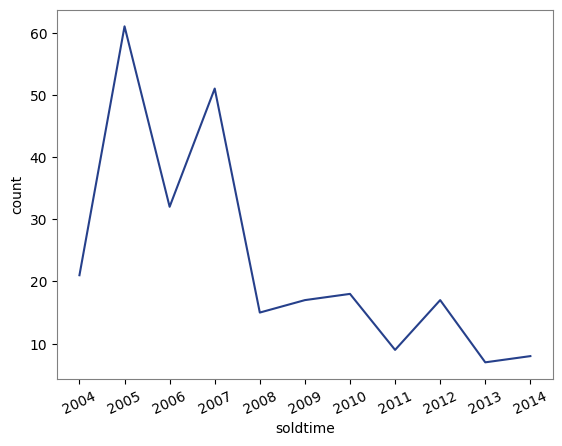

In [60]:
# plot timeline

sns.lineplot(x = "soldtime", y = "count", data = soldtime_counts_df_sorted_k, color='#26408B') 
  
plt.xticks(rotation = 25)

plt.show()

In [64]:
#comparison df

# Right merge the DataFrames on the 'soldtime' column
merged_df = pd.merge(soldtime_counts_df_sorted_dk, soldtime_counts_df_sorted_k, on='soldtime', how='right')

# Rename the count columns
merged_df.rename(columns={'count_x': 'de kooning count', 'count_y': 'klimt count'}, inplace=True)

# Replace NaN values with 0
merged_df.fillna(0, inplace=True)

# Convert the count columns to int64
merged_df['de kooning count'] = merged_df['de kooning count'].astype('int64')
merged_df['klimt count'] = merged_df['klimt count'].astype('int64')

# Sort by 'soldtime'
merged_df.sort_values(by='soldtime', inplace=True)

# Display the merged and sorted DataFrame
merged_df




,soldtime,de kooning count,klimt count
0,2004,0,21
1,2005,0,61
2,2006,0,32
3,2007,0,51
4,2008,48,15
5,2009,17,17
6,2010,34,18
7,2011,45,9
8,2012,41,17
9,2013,82,7


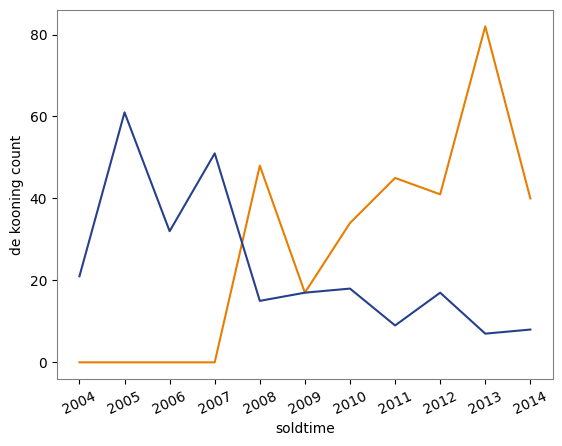

In [67]:
sns.lineplot(x = "soldtime", y = "de kooning count", data = merged_df, color='#E97D01') 
sns.lineplot(x = "soldtime", y = "klimt count", data = merged_df, color='#26408B')  
plt.xticks(rotation = 25)

plt.show()